<a href="https://colab.research.google.com/github/jan-kreischer/UZH_ML4NLP/blob/main/Project-01/index_jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 01 - Linear Classification




In [2]:
!pip install demoji

     |████████████████████████████████| 42 kB 1.8 MB/s 


In [1]:
! pip install alphabet-detector

  Created wheel for alphabet-detector: filename=alphabet_detector-0.0.7-py3-none-any.whl size=2443 sha256=f81f0ff0ed639c0214eb25ce5c8d58bf2ab5b0c22bcec2f35de7d3eed2b7fb2e
  Stored in directory: /root/.cache/pip/wheels/22/8c/ab/4afb1765f2b8450f894a1f06c9aa2b3f8e73f2fb8b55849e17
Successfully built alphabet-detector


## Imports

In [145]:
import csv
import re
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 200)  
pd.set_option('display.max_columns', 200)   
pd.set_option('display.width', 4000) 

from io import StringIO
import requests
import matplotlib.pyplot as plt

import demoji

from alphabet_detector import AlphabetDetector
ad = AlphabetDetector()

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [11]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

## Constants

In [104]:
TARGET_COLUMN = 'label'

## 1. Data Acquisition

In [125]:
def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [126]:
training_data = load_dataset(url_train_dev)
test_data = load_dataset(url_test)

In [127]:
dataset = pd.concat([training_data, test_data], axis=0) # Merge into one dataset for the pre-processing

In [128]:
print("The length of the combined dataset is {0} training samples + {1} test samples = {2} samples".format(len(training_data), len(test_data), len(dataset)))

The length of the combined dataset is 52675 training samples + 13279 test samples = 65954 samples


In [135]:
dataset = dataset.sample(frac=1).reset_index(drop=True) # Randomly shuffle the data

In [134]:
dataset.head(10)

,index,tweet,label
0,43350,Every athlete with passion for their respectiv...,en
1,39166,AutoCAD and Calculus for tomorrow. Fighting!,en
2,63465,@LukeKorns ily,und
3,34814,"Sabtu, 19 Juli 2014 Jam 09:27",id
4,5562,Unlock Her Legs http://t.co/pvrvc0hxdV,en
5,54735,ついに見てしまった！！！笑,ja
6,18046,クッキー気付いたら20枚食べてたわ,ja
7,22354,私がいつもバンＴでバイト行くき、バイト先の人からそんな男の子みたいな格好せんでもっと可愛い服...,ja
8,1720,After that appointment. Today officially sucks.,en
9,46016,@fleissmeister Chris the new bachelor?!!!! pl...,en


## 2. Data Exploration

In [88]:
def data_exploration(df, name=''):
  '''

  '''
  print('--- {} ---'.format(name))
  n_labels = len(np.unique(df["label"]))
  df = df.sort_values('label')
  print("{0} contains the columns: {1}".format(name, list(df.keys())))
  print("with a total of {} observations".format(len(df)))
  print("and {} different possible labels.".format(n_labels))
  print("The unique labels are {}".format(df["label"].unique()))
  plt.figure(figsize=(15, 3))
  plt.hist(df["label"], bins=n_labels)
  plt.xticks(rotation=90)
  plt.yscale("log")
  plt.xlabel("Language")
  plt.ylabel("#Occurences")
  plt.show()

---  ---
 contains the columns: ['tweet', 'label']
with a total of 65954 observations
and 78 different possible labels.
The unique labels are ['ar' 'ar_LATN' 'az' 'bg' 'bn' 'bs' 'ca' 'cs' 'cy' 'da' 'de' 'dv' 'el'
 'en' 'es' 'et' 'eu' 'fa' 'fi' 'fr' 'gl' 'ha' 'he' 'hi' 'hi-Latn' 'hr'
 'ht' 'hu' 'hy' 'id' 'is' 'it' 'ja' 'ja_LATN' 'jv' 'km' 'ko' 'ko_LATN'
 'la' 'lv' 'mk' 'mn' 'mr' 'ms' 'ne' 'nl' 'no' 'pl' 'ps' 'ps_LATN' 'pt'
 'ro' 'ru' 'si' 'sk' 'sl' 'sq' 'sr' 'su' 'sv' 'sw' 'ta' 'ta_LATN' 'th'
 'tl' 'tn' 'tr' 'uk' 'und' 'ur' 'ur_LATN' 'vi' 'wo' 'xh' 'yo' 'zh-CN'
 'zh-TW' 'zu']


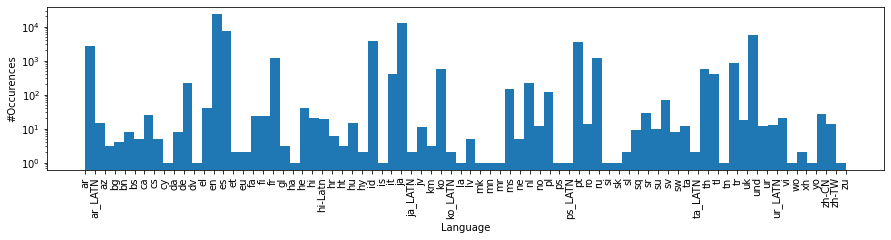

In [89]:
data_exploration(dataset, '')

## 3. Text Cleaning

This is generally a good idea as many text classification tools rely on counting the occurrences of words. If both upper and lower case versions of the same word are found in the text then the algorithm will count them as different words even though the meaning is the same. Of course this does mean that where the capitalised versions of a word exists, that does have a different meaning. For example the company Apple vs the fruit apple. This could result in poorer performance for some data sets. This is one area of NLP where you may try different methods to see how they affect the overall performance of the model.

In [40]:
def remove_all_emojis(text):
  dem = demoji.findall(text)
  for item in dem.keys():
    text = text.replace(item, '')
  return text

In [53]:
def  clean_data(df, column):
    df = df.copy(deep=True) # Make deep copy of tweets
    df[column] = df[column].str.lower() # Transform into all lowercase
    
    patterns = []
    retweet_pattern = '^RT'
    patterns.append(retweet_pattern)
    xml_pattern = '&\S+;'
    patterns.append(xml_pattern)
    hashtag_pattern = '#[A-Za-z0-9_]+'
    patterns.append(hashtag_pattern)
    twitter_mention_pattern = '@[A-Za-z0-9_]+'
    patterns.append(twitter_mention_pattern)
    http_pattern = 'http\S+'
    patterns.append(http_pattern)
    www_pattern = 'www\S+'
    patterns.append(www_pattern)
    tab_pattern = '\t'
    patterns.append(tab_pattern)
    punctuation_pattern = '[!"#$%&\\()*+,-./:;<=>?@\[\]^_`\'{}~]+'
    patterns.append(punctuation_pattern)
    numeric_pattern = '[0-9]+'
    patterns.append(numeric_pattern)
    regex = "|".join(patterns)

    #df[column] = df[column].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)) 
    df[column] = df[column].apply(lambda elem: re.sub(r"{}".format(regex), "", elem))
    df[column] = df[column].apply(remove_all_emojis)
    
    return df

In [ ]:
# Now we want to find out which special characters need to be removed from tweets in order to make the prediction better.
# We go over the printed list an not down the symbold which are not needed for language identification.
# These will be removed in a later step.
languages = list(np.unique(test_data['label']))
for language in languages:
  localized_tweets = training_data[training_data['label'] == language]
  # Clean and compare them
  cleaned_localized_tweets = clean_text(localized_tweets, 'tweet')
  comparison_view = pd.concat([localized_tweets.drop(['label'], axis=1), cleaned_localized_tweets], axis=1)
  print(comparison_view.head(5))
  #print(localized_tweets.head(5))
  print("---")

# Symbols like @<mention>, #, http://link !, numeric values (e.g 16000), " do not help for language identification.

In [102]:
cleaned_dataset = clean_data(dataset, "tweet")

In [103]:
pd.concat([dataset.drop(['label'], axis=1), cleaned_dataset], axis=1).sample(20, axis=0)

,tweet,tweet,label
21801,マスター、ピンチの時は私のスキル、「回復の歌」を使ってくださいね。 ＨＰが２５００回復しますよ。,マスター、ピンチの時は私のスキル、「回復の歌」を使ってくださいね。 ｈｐが２５００回復しますよ。,ja
59638,want a mcdonalds,want a mcdonalds,en
43368,やっべこれ超期待,やっべこれ超期待,ja
43195,予告編が出るようになって、マーニーの正体はがどっちなのか気になって気になって堪らない。 本屋...,予告編が出るようになって、マーニーの正体はがどっちなのか気になって気になって堪らない。 本屋...,ja
53016,ゆう、えりかたん、まこたん、りさ、ぽんた☜愛してます。って定期。,ゆう、えりかたん、まこたん、りさ、ぽんた☜愛してます。って定期。,ja
63232,"I've collected 15,807 gold coins! http://t.co/...",ive collected gold coins,en
56508,先生が生徒を呼び出しテストの答案を並べて生徒に尋ねた。「君の回答が君の隣の席の生徒と全く同じ...,先生が生徒を呼び出しテストの答案を並べて生徒に尋ねた。「君の回答が君の隣の席の生徒と全く同じ...,ja
5749,Jangan hiraukan mereka yg berusaha menjatuhkan...,jangan hiraukan mereka yg berusaha menjatuhkan...,id
30678,Love Madison 💕 http://t.co/aTkfk4I37q,love madison,en
15945,La copa se consigue punto a punto vamos x 3 pr...,la copa se consigue punto a punto vamos x pri...,es


# 4.Data Augmentation

## 4.1 Back translation

In [284]:
! pip install transformers
! pip install mosestokenizer
! pip install SentencePiece

     |████████████████████████████████| 2.9 MB 6.7 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 895 kB 36.3 MB/s 
     |████████████████████████████████| 3.3 MB 35.2 MB/s 
     |████████████████████████████████| 636 kB 41.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for mosestokenizer: filename=mosestokenizer-1.1.0-py3-none-any.whl size=49117 sha256=afa01154e7dc242dfc4287f3de2dc95980affe66336277b2da2936285d53685d
  Stored in directory: /root/.cache/pip/wheels/a7/31/94/fef279382208e85a65c1a7f5c4d0020115477b0af74f296b57
  Created wheel for toolwrapper: filename=toolwrapper-2.1.0-py3-none-any.whl size=3354 sha256=958bd3b671b269e1e1107585298c778ae66e9258b766df57012b3c1e7de750ed
  Stored in directory: /root/.cache/pip/wheels/c5/4f/33/54741ffe08e38ececb1d28068a153729b4fe820bafa0a0691f
  Created wheel for uctoo

In [ ]:
import transformers, mosestokenizer

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

# Helper function to download data for a language
def download(model_name):
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    return tokenizer, model



# download model for English -> Romance
#tmp_lang_tokenizer, tmp_lang_model = download('Helsinki-NLP/opus-mt-en-ROMANCE')
# download model for Romance -> English
#src_lang_tokenizer, src_lang_model = download('Helsinki-NLP/opus-mt-ROMANCE-en')



def translate(texts, model, tokenizer, language):
    """Translate texts into a target language"""
    # Format the text as expected by the model
    formatter_fn = lambda txt: f"{txt}" if language == "en" else f">>{language}<< {txt}"
    original_texts = [formatter_fn(txt) for txt in texts]

    # Tokenize (text to tokens)
    tokens = tokenizer.prepare_seq2seq_batch(original_texts)

    # Translate
    translated = model.generate(**tokens)

    # Decode (tokens to text)
    translated_texts = tokenizer.batch_decode(translated, skip_special_tokens=True)

    return translated_texts


def back_translate(texts, language_src, language_dst):
    """Implements back translation"""
    # Translate from source to target language
    translated = translate(texts, tmp_lang_model, tmp_lang_tokenizer, language_dst)

    # Translate from target language back to source language
    back_translated = translate(translated, src_lang_model, src_lang_tokenizer, language_src)

    return back_translated




In [ ]:
model_name = 'Helsinki-NLP/opus-mt-aav-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
tokenizer.supported_language_codes

AttributeError: ignored

In [ ]:
language_code_list =df_train_dev['label'].unique

def get_one_language_data(df, n):
  #get the n'th set of language from df_train_dev
  df_one_lang=df[df['label'].isin([language_code_list[n]])]
  return df_one_lang

def generate_new_rows(df_one_lang):
  lable=df_one_lang['label']
  df_one_lang_new = pd.DataFrame(columns=['text','label'])
  for rows in df_one_lang.itterows():
    new_lang = back_translate(df_one_lang['text'],label,'en')
    df_one_lang_new.append({'text':new_lang,'label'label})
    df_one_lang=df_one_lang.append(df_one_lang_new)
  return df_one_lang

def augdata_by_back_translation(df):
  df_new = pd.DataFrame(columns=['text','label'])
  for n in range(0,len(language_code_list)):
    df_one_lang_new = generate_new_rows(get_one_language_data(df,n))
    df_new = df_new.append(df_one_lang_new)
  return df_new



,tweet,label
0,يا من أناديها ويخنقني البكاء ويكاد صمت الدمع ...,ar
1,فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...,ar
2,ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...,ar
3,يا ابو سلو عرفتني,ar
4,ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله م...,ar
...,...,...
52670,其實我很想問，噗浪怎麼鎖回應然後又開啟的#### http://t.co/sQBh6jmVoW,zh-TW
52671,我喜歡一部 @YouTube 影片 http://t.co/Kouv0xaEos FIGHT...,zh-TW
52672,一分鐘世界盃！http://t.co/yEvaMrp7ki,zh-TW
52673,{CWB} 桃園縣 一週天氣預報(07/27 05:00發布): 07/27 白天 溫度:2...,zh-TW


![back_translation.png](attachment:back_translation.png)

## 2.2 Bigram flipping














In [ ]:
def augdata_by_bigram_flipping(df):

  return df_new

##  2.3 Replacing Entities

In [ ]:
def augdata_by_replacing_entities(df):

  return df_new

# 5.Pre-Processing

# 6.Feature Engineering


In [136]:
def detect_alphabet(df, column):
  df['alphabet'] = df[column].apply(lambda tweet: list(ad.detect_alphabet(tweet)))
  mlb = MultiLabelBinarizer()
  df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('alphabet')),
                            columns=mlb.classes_,
                            index=df.index))
  return df

In [137]:
dataset_w_alphabet = detect_alphabet(dataset, 'tweet')

In [139]:
dataset_w_alphabet.head(10)

,index,tweet,label,ANGSTROM,ARABIC,ARMENIAN,BENGALI,BLACK-LETTER,BOPOMOFO,CANADIAN,CARON,CJK,CYRILLIC,DEVANAGARI,FEMININE,FULLWIDTH,GEORGIAN,GREEK,GUJARATI,GURMUKHI,HALFWIDTH,HANGUL,HEBREW,HIRAGANA,IDEOGRAPHIC,KANNADA,KATAKANA,KATAKANA-HIRAGANA,KHMER,LAO,LATIN,MASCULINE,MICRO,MODIFIER,ORIYA,SCRIPT,SINHALA,TAMIL,TELUGU,THAI,TIBETAN,YI
0,44082,"Yeah , I Can't Do This !",en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,32973,The Hangover 3 is a yawn,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,38888,بغى يروح غلطة كاميرا خفيه http://t.co/lpnZX8k...,ar,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,56483,I've harvested 60 of food! http://t.co/9VtaeM2...,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,58096,"Lol, it's because of Luis Suarez""@Footy_Jokes:...",en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,34504,Pierre Edmonds meeting @HughesFT @TheLondonBea...,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,47922,cuando vienes a puntaa? — cuando aga un poco d...,es,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,43694,من باب راحة الصدر ؟ استغفر الله العظيم و اتو...,ar,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,65290,@Paulcraig20 u r a liar,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,23591,Brito pone parte de lo que robó con #Ciccone. ...,es,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


# 7.Modeling 

In [140]:
def train_val_test_split(X, y, test_size=0.3, val_size=1/3):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)
  X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=val_size, shuffle=True)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [141]:
X = dataset_w_alphabet.drop([TARGET_COLUMN, 'tweet'], axis=1)
y = dataset_w_alphabet[TARGET_COLUMN]
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

In [143]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(max_iter=1000, tol=0.01, verbose=True)
sgdc.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Streaming output truncated to the last 5000 lines.
Norm: 251.88, NNZs: 11, Bias: -7.589198, T: 1246509, Avg. loss: 887.820400
Total training time: 0.18 seconds.
-- Epoch 28
Norm: 199.53, NNZs: 12, Bias: -7.573275, T: 1292676, Avg. loss: 955.522594
Total training time: 0.19 seconds.
-- Epoch 29
Norm: 2.62, NNZs: 12, Bias: -7.558061, T: 1338843, Avg. loss: 796.316823
Total training time: 0.19 seconds.
-- Epoch 30
Norm: 210.87, NNZs: 13, Bias: -7.558087, T: 1385010, Avg. loss: 863.333311
Total training time: 0.20 seconds.
-- Epoch 31
Norm: 52.78, NNZs: 13, Bias: -7.543950, T: 1431177, Avg. loss: 739.633082
Total training time: 0.21 seconds.
-- Epoch 32
Norm: 226.55, NNZs: 13, Bias: -7.530154, T: 1477344, Avg. loss: 880.948785
Total training time: 0.21 seconds.
-- Epoch 33
Norm: 1.70, NNZs: 13, Bias: -7.529892, T: 1523511, Avg. loss: 690.276900
Total training time: 0.22 seconds.
-- Epoch 34
Norm: 174.12, NNZs: 13, Bias: -7.542870, T: 1569678, Avg. loss: 610.384634
Total training time: 0.23

[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   52.7s finished


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.01,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [153]:
np.set_printoptions(threshold=100)

y_pred = sgdc.predict(X_test)

confusion_matrix(y_test, y_pred)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [150]:
cr = classification_report(y_test, y_pred)
print(cr)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          ar       0.00      0.00      0.00       525
     ar_LATN       0.00      0.00      0.00         5
          bn       0.00      0.00      0.00         1
          bs       0.00      0.00      0.00         2
          ca       0.00      0.00      0.00         5
          da       0.00      0.00      0.00         2
          de       0.00      0.00      0.00        40
          el       0.00      0.00      0.00        12
          en       1.00      0.00      0.00      4588
          es       0.00      0.00      0.00      1517
          et       0.00      0.00      0.00         1
          eu       0.00      0.00      0.00         2
          fa       0.00      0.00      0.00         8
          fi       0.00      0.00      0.00         4
          fr       0.00      0.00      0.00       228
          gl       0.00      0.00      0.00         1
          he       0.00      0.00      0.00        11
          hi       0.00    

#8.Evaluation